<a href="https://colab.research.google.com/github/araghu24/hello-world/blob/master/Abi_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
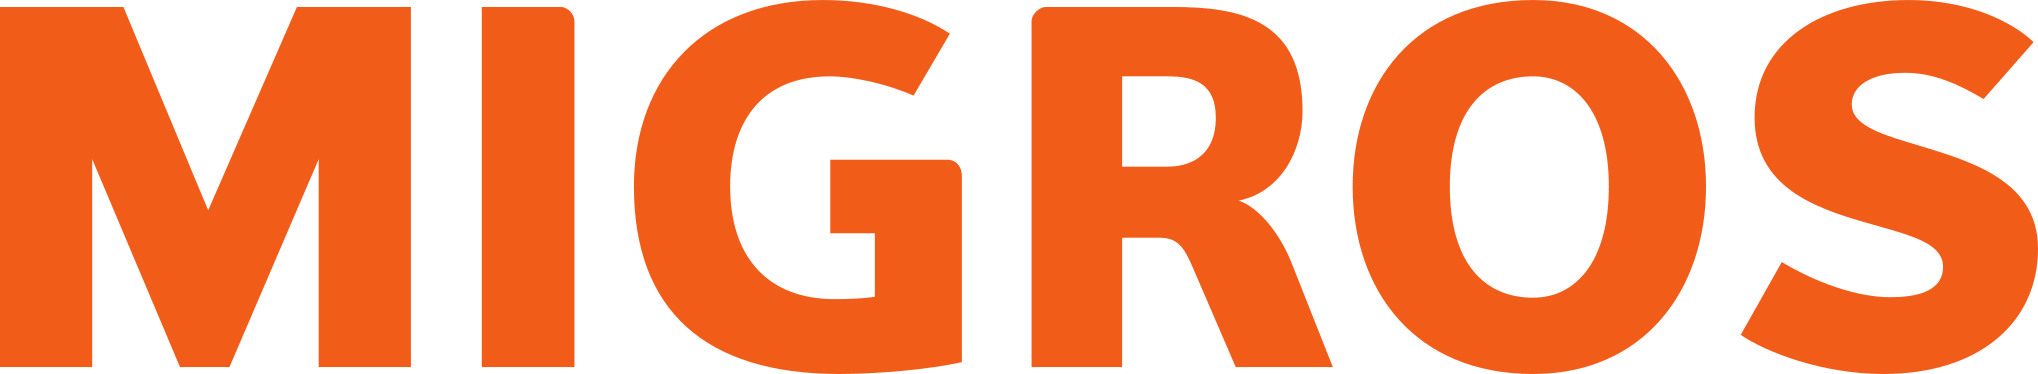
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).


In this first iteration we just fit the training data in the Logistic regression and observe the accuracy.


In [1]:
#clear output
%%capture 
#Importing useful extensions
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import re

In [ ]:
# Install and update spaCy
!pip install -U spacy

!python -m spacy download en
import spacy
from spacy import displacy


Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.4)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
sp = spacy.load('en_core_web_sm')

In [3]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [3]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(5)

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball


In [ ]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

##Exploratory data analysis

1.   Base rate
2.   List item


####1. Base rate
This indicate how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [4]:
#Base rate of the train df
df_train['target'].value_counts() /len(df_train) 

#The base rate of this dataframe is 0.572

0    0.571936
1    0.428064
Name: target, dtype: float64

1.1 Clean dataset

In [5]:
df_train =  df_train.drop_duplicates(subset=['text'], keep='first')


In [6]:
#removing tags

def remove_tags(text):
  text = re.sub(r'@\S+','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))


In [9]:
#replacing "%20" with space

df_train['keyword'] = df_train['keyword'].replace('%20', ' ', regex = True)
df_train['text'] = df_train['text'].replace('%20', ' ', regex = True)


In [7]:
#removing url
def remove_url(text):
  text = re.sub(r'http\S+', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))



In [10]:
#removing punctuation

def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))



In [11]:
#removing noises

def remove_noice(text):
  text = re.sub('RT', '', text)
  text = re.sub('rT', '', text)
  text = re.sub('Rt', '', text)
  text = re.sub('rt', '', text)
  text = re.sub('IB', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_noice(x))


In [19]:
from google.colab import files
df_train.to_csv('train.csv')
files.download("train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.2 Create Tokenizer

In [ ]:
#Create Tokenizer

# Define stopwords, punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
numbers = "0123456789"
noise = list(['RT', 'rt', 'Rt', 'rT', 'IB'])


sp = spacy.load('en_core_web_sm')

#Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = sp(sentence)

# Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]  
# Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]

# Remove Noise 
    mytokens = [word for word in mytokens if word not in noise]
 
 # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
      for char in word:
        if (char in punctuations) or (char in numbers):
          word = word.replace(char, "")
      if word != "":
        mytokens_2.append(word)


# Return preprocessed list of tokens
    return mytokens_2

#demo
review = text.sample()
review.values[0]

'Hmmthis could be problem for some researchers FedEx no longer to transpo select agents covIibxgjAV via '

In [ ]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

####Logistic regression and pipeline

1.   First attempt iteration of the model: No treatement of the dataframe, just fitted in a logistic regression. 
2.   List item

In [ ]:
#Setting up the train test split
features = ['keyword', 'location', 'text']

#First for the training data
X = text
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7fded85ce2f0>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

####Accuracy

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8934
CONFUSION MATRIX:
[[2885   76]
 [ 476 1739]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TRAIN ACCURACY SCORE:
0.7954
CONFUSION MATRIX:
[[664  76]
 [189 366]]


####Submission
Fit on the test dataframe to submit on AIcrowd

In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

In [ ]:
sample_submission.assign(target = target_test)
sample_submission.to_csv('submission-1.csv', index=False)